# NVD Global Dataset Exploratory Data Analysis
#### Supporting Questions
- 

## Importing Libraries
We'll be using Pandas and NumPy because they give us the ability to clean, arrange, modify, organize, and analyze datasets. We'll use Matplotlib for visualizing the data and we'll use Seaborn to add aesthetic flair to the visualizations. We'll also add support for regular expressions to check which CVEs have a relation to IoT vulnerabilities.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Loading the Data
Firstly, we'll look at the shape of the dataset and see how many sheets it contains and the first few records to get a sense of what the dataset contains. We can conclude from the data that it contains a CVE ID, multiple types of severity scores, a description, a CWE ID, and runs from 1999 to 2021.

In [3]:
# See how many sheets the data has
sheet_names = pd.ExcelFile('../data/Global_Dataset.xlsx').sheet_names
print(sheet_names)

['Sheet1']


In [4]:
# IoT_CVEs = pd.read_excel('MITRE_2024_IoT_CVEs.xlsx', sheet_name='2024 IoT CVEs')
# CVEs_4yrs = pd.read_excel('MITRE_2024_IoT_CVEs.xlsx', sheet_name='2020-2024 CVEs')
# CVEs_5yrs = pd.read_excel('MITRE_2024_IoT_CVEs.xlsx', sheet_name='2019-2024 CVEs')
# print(IoT_CVEs.describe())
# print(CVEs_4yrs.describe())
# print(CVEs_5yrs.describe())

df = pd.read_excel('../data/Global_Dataset.xlsx')
rows, columns = df.shape
print(f'The Global Dataset has {rows} records and {columns} attributes\n-----\n')
df.head() # View the head

The Global Dataset has 169566 records and 7 attributes
-----



,ID,CVE-ID,CVSS-V3,CVSS-V2,SEVERITY,DESCRIPTION,CWE-ID
0,1,CVE-1999-0001,NaN,5.0,MEDIUM,ip_input.c in BSD-derived TCP/IP implementatio...,CWE-20
1,2,CVE-1999-0002,NaN,10.0,HIGH,Buffer overflow in NFS mountd gives root acces...,CWE-119
2,3,CVE-1999-0003,NaN,10.0,HIGH,Execute commands as root via buffer overflow i...,NVD-CWE-Other
3,4,CVE-1999-0004,NaN,5.0,MEDIUM,"MIME buffer overflow in email clients, e.g. So...",NVD-CWE-Other
4,5,CVE-1999-0005,NaN,10.0,HIGH,Arbitrary command execution via IMAP buffer ov...,NVD-CWE-Other


In [5]:
df.tail() # View the tail

,ID,CVE-ID,CVSS-V3,CVSS-V2,SEVERITY,DESCRIPTION,CWE-ID
169561,169562,CVE-2021-45470,7.5,5.0,HIGH,lib/DatabaseLayer.py in cve-search before 4.1....,NVD-CWE-Other
169562,169563,CVE-2021-45471,5.3,5.0,MEDIUM,"In MediaWiki through 1.37, blocked IP addresse...",NVD-CWE-noinfo
169563,169564,CVE-2021-45472,6.1,4.3,MEDIUM,"In MediaWiki through 1.37, XSS can occur in Wi...",CWE-79
169564,169565,CVE-2021-45473,6.1,4.3,MEDIUM,"In MediaWiki through 1.37, Wikibase item descr...",CWE-79
169565,169566,CVE-2021-45474,6.1,4.3,MEDIUM,"In MediaWiki through 1.37, the Special:ImportF...",CWE-79


## Preprocessing The Data
### Checking For Null Values
There are no null values in the <span style='background-color:#005566;color:white;border-radius:4px;padding:2px 6px'>CVE-ID</span> and <span style='background-color:#005566;color:white;border-radius:4px;padding:2px 6px'>DESCRIPTIONS</span>, which makes it possible to search for those CVEs which have descriptions related to certain vulnerabilities and then figure out the prevalance of these compared to the rest of the CVEs.The Common Severity Scoring System however, particularly version 3, is nearly half empty. If the null values in the version 2 and <span style='background-color:#005566;color:white;border-radius:4px;padding:2px 6px'>SEVERITY</span> columns prove to be sufficiently random, they can be safely dropped from the dataset. We'll check for their randomness in a later cell after gathering some more basic stats. 

In [4]:
# Check for nulls
null_values = df.isnull().sum()
print('Null values in each column:')
print(null_values)

Null values in each column:
ID                 0
CVE-ID             0
CVSS-V3        74007
CVSS-V2          105
SEVERITY          86
DESCRIPTION        0
CWE-ID             0
dtype: int64


### Handling Null Values
The number of missing values compared to the total is very small. If they are randomly distributed, then we'll have no issue dropping their records from the dataset. The issue is that if there is a correlation between the missing values and other attributes, we'd introduce bias if we dropped them without further processing. So we'll start by computing the correlation between the missing values in the <span style='background-color:#005566;color:white;border-radius:4px;padding:2px 6px'>CVSS-V2</span> and <span style='background-color:#005566;color:white;border-radius:4px;padding:2px 6px'>SEVERITY</span> columns.

In [5]:
# Compute correlation here?

### Checking For Duplicates
Next, we'll check for duplicates. No absolute duplicates exist when taking the whole dataset into account, but every column of worth contains internal duplicates, suggesting that specific CVE IDs have multiple descriptions, severity scores, and CWE IDs, perhaps because these specific CVEs might affect multiple tools, software, systems, and other products. There's a remarkably high amount of duplicate CWE IDs. Thousands of these IDs are either designated "other" or "noinfo". In a later cell, we can try to join the Global Dataset table with a datset that includes descriptions for the defined CWEs, and from there we can run the same kind of keyword association search we're going to do for CVE IDs and their descriptions in this dataset.

In [36]:
# Check for duplicates
duplicates = df.duplicated().sum()
print('Number of duplicates in the total dataset:', duplicates, '\n-----\n')

# Duplicate check within CVE ID attribute
CVE_ID_dups = df['CVE-ID'].duplicated().sum()
print('Number of duplicate CVE IDs:', CVE_ID_dups, '\n-----\n')

# Deconstruct the severity attribute, e.g. what are the categories, how many records belong to each
severity_cat = df['SEVERITY' ].unique()
print('Severity categories:', severity_cat, '\n-----\n')

df['SEVERITY'] = df['SEVERITY'].fillna('UNKNOWN')
print('Number of null values in SEVERITY after filling:', df['SEVERITY'].isnull().sum(), '\n-----\n')

severity_value_counts = df['SEVERITY'].value_counts()
print('Severity value counts:\n', severity_value_counts, '\n-----\n')

# Duplicate check within the description column
desc_dups = df['DESCRIPTION'].duplicated().sum()
print('Number of duplicate descriptions:', desc_dups, '\n-----\n')

# Deconstruct the CWE attribute, e.g. what are the categories, how many records belong to each
CWE_dups = df['CWE-ID'].duplicated().sum()
CWE_value_counts = df['CWE-ID'].value_counts()
CWE_unique = df['CWE-ID'].unique()
print('CWE value counts:\n', CWE_value_counts, '\n')
print('Number of duplicate CWEs', CWE_dups, '\n')
# print('Unique CWE values:', CWE_unique) # Useful for when we have CWE description data

Number of duplicates in the total dataset: 0 
-----

Number of duplicate CVE IDs: 3229 
-----

Severity categories: ['MEDIUM' 'HIGH' 'LOW' 'CRITICAL' 'UNKNOWN'] 
-----

Number of null values in SEVERITY after filling: 0 
-----

Severity value counts:
 SEVERITY
MEDIUM      76460
HIGH        71617
CRITICAL    14198
LOW          7205
UNKNOWN        86
Name: count, dtype: int64 
-----

Number of duplicate descriptions: 7967 
-----

CWE value counts:
 CWE-ID
NVD-CWE-Other     26834
NVD-CWE-noinfo    18615
CWE-79            17438
CWE-119           11494
CWE-20             8575
                  ...  
CWE-279               1
CWE-603               1
CWE-684               1
CWE-334               1
CWE-775               1
Name: count, Length: 306, dtype: int64 

Number of duplicate CWEs 169260 



## Focusing on Target Years
Every CVE ID contains within it the year in which is was discovered. We can pull that year out into a dedicate column so that we can exclusively look at the years of interest (2016-2021). Once we've derived the year, we can select only those rows whose year corresponds to our needs.

In [20]:
df['YEAR'] = df['CVE-ID'].str[4:8].astype(int) # Slice the CVE ID for the year and convert it to an integer
new_df = df[df['YEAR'] >= 2016] # Create new dataframe where YEAR >= 2019
print(new_df.head())

          ID         CVE-ID  CVSS-V3  CVSS-V2  SEVERITY  \
78856  78857  CVE-2016-0002      7.5      7.6      HIGH   
78857  78858  CVE-2016-0003      9.6      9.3  CRITICAL   
78858  78859  CVE-2016-0005      4.3      4.3    MEDIUM   
78859  78860  CVE-2016-0006      7.3      6.9      HIGH   
78860  78861  CVE-2016-0007      7.8      6.9      HIGH   

                                             DESCRIPTION   CWE-ID  YEAR  
78856  The Microsoft (1) VBScript 5.7 and 5.8 and (2)...  CWE-119  2016  
78857  Microsoft Edge allows remote attackers to exec...  CWE-119  2016  
78858  Microsoft Internet Explorer 9 through 11 allow...   CWE-20  2016  
78859  The sandbox implementation in Microsoft Window...  CWE-264  2016  
78860  The sandbox implementation in Microsoft Window...  CWE-264  2016  


## IoT-Related CVE Analysis
Let's look for the CVEs whose descriptions have certain keywords related to the vulnerabilities that are associated with Nation-State Threat Actors' exploitation of IoT devices. We'll do this with the power of regular expressions, which will search for lexical variations of the following keywords: patch, firmware, legacy, IoT, infrastructure, and update. With this information, we calculate the frequency of such CVEs and their representation among severity levels. Most of these CVEs have a high severity index.

Number of IoT vulnerability-related CVEs: 7907
Frequency of IoT-related CVEs: 8.72%
Frequency of non-IoT-related CVEs: 91.28%



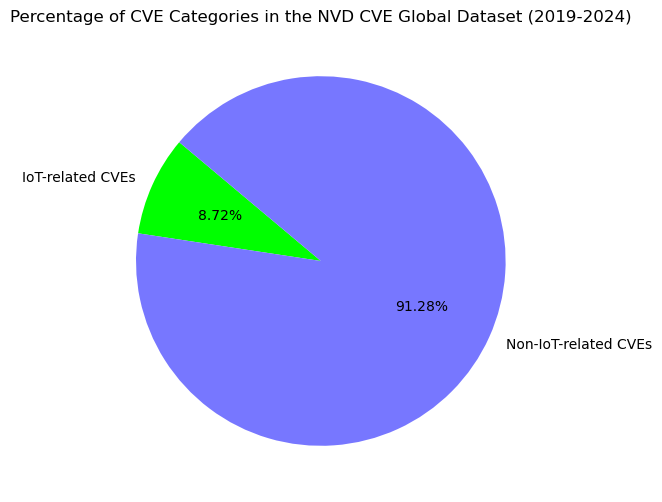

Severity of these CVEs:
 SEVERITY
HIGH        3695
MEDIUM      2586
CRITICAL    1478
LOW          144
UNKNOWN        4
Name: count, dtype: int64 

SEVERITY
HIGH        46.73
MEDIUM      32.71
CRITICAL    18.69
LOW          1.82
UNKNOWN      0.05
Name: count, dtype: float64 



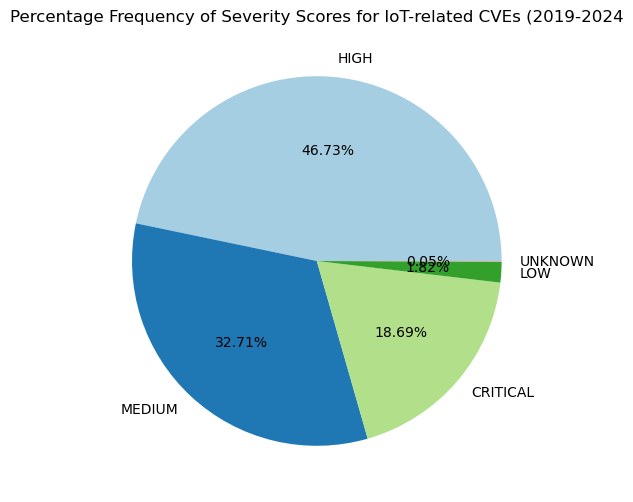

In [21]:
# IoT_vulnerability_related_keywords regex
IoT_keyword_regex = (
    r'\bpatch(?:ing|ed|es)?\b|'                                 # patch, patching, patched, patches
    r'\bfirmware(?:s)?\b|'                                      # firmware
    r'\blegacy\b|'                                              # legacy
    r'\bIoT\b|'                                                 # IoT
    r'\binfrastructur(?:e|al|es)?\b|'                           # infrastructure, infrastructural, infrastructures
    r'\bupdate(?:s|d|ing)\b|'                                   # update, updates, updated
    r'\bOT\b|'                                                  # OT
    r'\bout-?dated\b|'                                          # outdated, out-dated
    r'\bout-?dated systems\b|'                                  # outdated systems, out-dated systems
    r'\b(?:bot-?net|botnet)\b|'                                 # botnet, bot-net
    r'\bDDoS\b|'                                                # DDoS
    r'\bDistributed Denial of Service\b|'                       # Distributed Denial of Service or DDoS
    r'\bolder system(?:s)?\b|'                                  # older systems
    r'\bICS\b|'                                                 # ICS
    r'\bSIS\b|'                                                 # SIS
    r'\b(?:trek TCP/IP stack|TCP/IP|(?:TCP|IP))\b|'             # trek TCP/IP stack, TCP/IP, TCP, IP
    r'\bpersistent threat(?:s|ening)?\b|'                       # persistent threat
    r'\bsoftware update(?:s|d)\b|'                              # software update
    r'\b(?:supervisory control and data acquisition|SCADA)\b'   # SCADA or Supervisory Control and Data Acquisition
)

IoT_CVEs = new_df['DESCRIPTION'].str.contains(IoT_keyword_regex, flags=re.IGNORECASE, regex=True) # Searches for the keywords in the description column

total_CVEs = len(new_df['CVE-ID']) # Total number of CVEs
IoT_CVEs_count = IoT_CVEs.sum() # Total number of IoT-related CVEs
non_IoT_CVEs = total_CVEs - IoT_CVEs_count # Total number of non-IoT-related CVEs
print('Number of IoT vulnerability-related CVEs:', IoT_CVEs_count)

# Calculate frequency percentage
IoT_CVE_freq = round((IoT_CVEs_count / total_CVEs) * 100, 2)
non_IoT_CVE_freq = round(100 - IoT_CVE_freq, 2)
print(f'Frequency of IoT-related CVEs: {IoT_CVE_freq}%')
print(f'Frequency of non-IoT-related CVEs: {non_IoT_CVE_freq}%\n')

# Create data for pie chart
labels = ['IoT-related CVEs', 'Non-IoT-related CVEs']
sizes = [IoT_CVEs_count, non_IoT_CVEs]
colors = ['#00ff00', '#7777ff']

plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors, startangle=140)
plt.title('Percentage of CVE Categories in the NVD CVE Global Dataset (2019-2024)')
plt.show()

IoT_CVE_df = new_df[IoT_CVEs]
IoT_CVE_df_severity_value_counts = IoT_CVE_df['SEVERITY'].value_counts()
print('Severity of these CVEs:\n', IoT_CVE_df_severity_value_counts, '\n')

severity_percentages = round((IoT_CVE_df_severity_value_counts / IoT_CVE_df_severity_value_counts.sum()) * 100, 2)
print(severity_percentages, '\n')

# Visualize the severity in a piechart
plt.figure(figsize=(8,6))
plt.pie(severity_percentages, labels=severity_percentages.index, autopct='%1.2f%%', colors=plt.cm.Paired.colors)
plt.title('Percentage Frequency of Severity Scores for IoT-related CVEs (2019-2024')
plt.show()

## Time-Series Analysis
Let's see the prevalence of these IoT-related CVEs by year. There seems to be a huge spike of CVEs discovered in 2020, alongside a general northward trend. Further analysis will help determine if this is a linear or logarithmic. We'll also group the data by 

CVEs per year:
 YEAR
2016     9504
2017    14638
2018    15933
2019    16007
2020    18608
2021    16020
Name: YEAR, dtype: int64 
-----



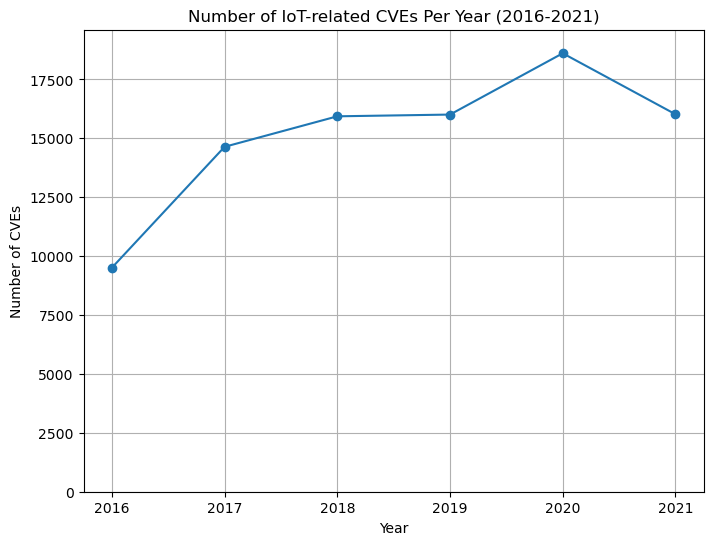

<Figure size 800x600 with 0 Axes>

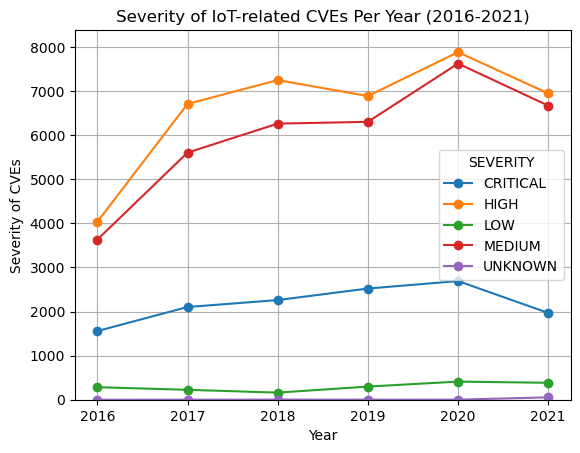

In [59]:
cve_per_year = new_df.groupby('YEAR')['YEAR'].size()
print('CVEs per year:\n', cve_per_year, '\n-----\n')

# Plot the number of CVEs per year
plt.figure(figsize=(8,6))
cve_per_year.plot(kind='line', marker='o', title='Number of IoT-related CVEs Per Year (2016-2021)')
plt.xlabel('Year')
plt.ylabel('Number of CVEs')

# Define limits of Y axis
plt.ylim(0, cve_per_year.max() + 1000)

plt.grid(True) # Show a grid to help align values to their axes
plt.show()

# Plot the severity of CVEs by year
cve_severity_by_year = new_df.groupby(['YEAR', 'SEVERITY'])['SEVERITY'].count().unstack(fill_value=0)
plt.figure(figsize=(8,6))
cve_severity_by_year.plot(kind='line', marker='o', title='Severity of IoT-related CVEs Per Year (2016-2021)')
plt.xlabel('Year')
plt.ylabel('Severity of CVEs')

# Define limits of Y axis
plt.ylim(0, cve_severity_by_year.max().max() + 500)

plt.grid(True) # Show a grid to help align values to their axes
plt.show()